# Проверка гипотез по информации о количестве больничных дней у работников

1)	Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.
2)	Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from scipy.stats import mannwhitneyu, kstest, ttest_ind, beta

sns.set()
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
np.random.seed(42)

In [2]:
days = 2
age = 35

## Загрузка и обработка данных

Решила сделать и перегон из Excel файлов, которые предоставляются, как исходные данные, в csv формат, и чтение из этого файла.

Далее меняем имена столбцов на указанные в задании. Пол - sex, возраст - age, количество больничных дней - work_days.

Заменяем категориальный тип данных в sex на числовой, чтобы потом можно было смотреть корреляции пола и количества больничных дней.

In [3]:
read_file = pd.read_excel('data.xlsx')

In [4]:
read_file.to_csv('data.csv', 
                  index = None,
                  encoding='cp1251',
                  header=True)

In [5]:
df = pd.read_csv('data.csv', sep=',', encoding='cp1251')  
df.rename(columns={'Количество больничных дней': 'work_days', 'Возраст': 'age', 'Пол' : 'sex'}, inplace=True)
df['sex'].replace(['М', 'Ж'], [0, 1], inplace=True)
df

,work_days,age,sex
0,5,39,1
1,4,54,0
2,4,26,0
3,5,42,0
4,4,29,0
...,...,...,...
232,5,30,0
233,4,36,1
234,2,60,1
235,2,44,1


## Проверка 1 гипотезы

Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.

С помощью гистограм можем увидеть, что плотности распределения количества дней болезни очень похожи.

In [6]:
male = df[df['sex'] == 0]['work_days']
female = df[df['sex'] == 1]['work_days']

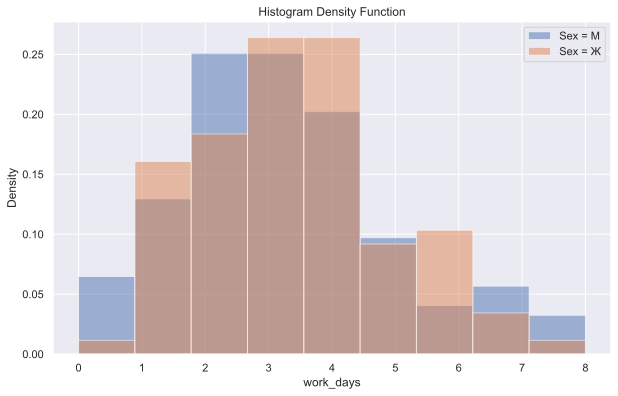

In [7]:
plt.title('Histogram Density Function')
plt.hist(male, density=True, alpha=0.5, label='Sex = М', bins=9)
plt.hist(female, density=True, alpha=0.5, label='Sex = Ж', bins=9)
plt.xlabel('work_days')
plt.ylabel('Density')
plt.legend()
plt.show()

Проверять гипотезу о сильной различности частоты болезней будем с помощью гипотез, позволяющих обнаружить одинаковость или различие данных, то есть гипотез об однородности распределений. Нулевая гипотеза будет гипотеза об одинаковости распределений частоты болезней более двух дней для разных полов, альтернативная о том, что мужчины болеют чаще, чем женщины.

In [8]:
df['more_n_days'] = np.where(df['work_days'] > days, 1, 0)

male = df[df['sex'] == 0]['more_n_days']
female = df[df['sex'] == 1]['more_n_days']

In [9]:
print(f" Частота пропуска у мужчин {sum(male) / len(male):.4f}")
print(f" Частота пропуска у женщин {sum(female) / len(female):.4f}")

 Частота пропуска у мужчин 0.6043
 Частота пропуска у женщин 0.6837


In [10]:
stat, p_value = mannwhitneyu(male, female, alternative='greater', method='exact')
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=6270.5000, p-value=0.8509


p-value большое, не можем отклонить нулевую гипотезу о равенстве распределений.

In [11]:
stat, p_value = kstest(male, female, alternative='greater', method='exact')
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.0794, p-value=0.4539


p-value большое, не можем отклонить нулевую гипотезу о равенстве распределений.

In [12]:
sample_stat = np.mean(male) - np.mean(female)
stats = np.zeros(1000)
for k in range(1000):
  labels = np.random.permutation((df['sex'] == 0).values)
  stats[k] = np.mean(df.more_n_days[labels]) - np.mean(df.more_n_days[labels==False])
p_value = np.mean(stats > sample_stat)

print(f"Permutation Test: p-value={p_value:.4f}")

Permutation Test: p-value=0.8460


p-value большое, не можем отклонить нулевую гипотезу о равенстве распределений.

Попробуем проверить с помощью A/B теста, где тестовой группой будут пропуски более двух дней у мужчин, контрольной группой будут пропуски более двух дней у женщин, conversation rate будет доля пропуска более двух дней в каждой группе. Тогда получаем следующие результаты, которые не позволяют говорить о том, что мужчины болеют чаще женщин.

In [13]:
from math import lgamma

def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

def ab_test(old, new):
    #This is the known data: impressions and conversions for the Control and Test set
    imps_ctrl, convs_ctrl = len(old), sum(old)
    imps_test, convs_test = len(new), sum(new)

    #here we create the Beta functions for the two sets
    a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
    beta_C = beta(a_C, b_C)
    a_T, b_T = convs_test+1, imps_test-convs_test+1
    beta_T = beta(a_T, b_T)

    #calculating the lift
    lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()

    #calculating the probability for Test to be better than Control
    prob=calc_prob_between(beta_T, beta_C)

    print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")

In [14]:
ab_test(female, male)

Test option lift Conversion Rates by -11.35% with 10.8% probability.


## Проверка 2 гипотезы

Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

Анализ гистограмм количества пропущенных дней позволяет утверждать, что для разных возрастных групп есть различия в количестве пропущенных дней.

In [15]:
old = df[df['age'] > age]['work_days']
young = df[df['age'] <= age]['work_days']

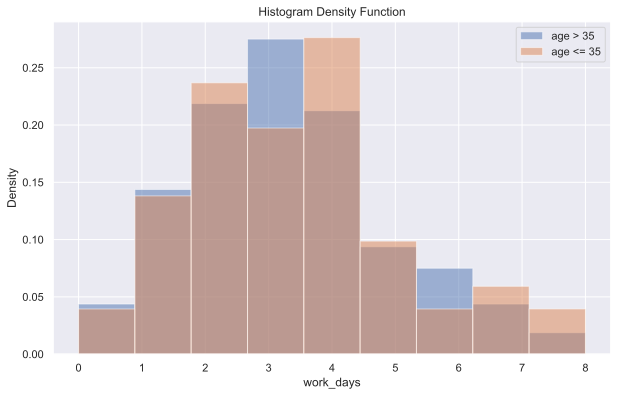

In [16]:
plt.title('Histogram Density Function')
plt.hist(old, density=True, alpha=0.5, label='age > ' + str(age), bins=9)
plt.hist(young, density=True, alpha=0.5, label='age <= ' + str(age), bins=9)
plt.xlabel('work_days')
plt.ylabel('Density')
plt.legend()
plt.show()

Анализ гистограммы для частоты пропуска более двух дней разными возрастными группами не дает сильных отличий.

In [17]:
old = df[df['age'] > age]['more_n_days']
young = df[df['age'] <= age]['more_n_days']

In [18]:
print(f" Частота пропуска у людей старше {age} {sum(old) / len(old):.4f}")
print(f" Частота пропуска у людей младше {age} {sum(young) / len(young):.4f}")

 Частота пропуска у людей старше 35 0.6389
 Частота пропуска у людей младше 35 0.6316


In [19]:
stat, p_value = mannwhitneyu(old, young, alternative='greater', method='exact')
print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=5167.5000, p-value=0.4678


p-value большое, не можем отклонить нулевую гипотезу о равенстве распределений.

In [20]:
stat, p_value = kstest(old, young, alternative='greater', method='exact')
print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Kolmogorov-Smirnov Test: statistic=0.0000, p-value=1.0000


p-value большое, не можем отклонить нулевую гипотезу о равенстве распределений.

In [21]:
sample_stat = np.mean(old) - np.mean(young)
stats = np.zeros(1000)
for k in range(1000):
  labels = np.random.permutation((df['age'] > 35).values)
  stats[k] = np.mean(df.more_n_days[labels]) - np.mean(df.more_n_days[labels==False])
p_value = np.mean(stats > sample_stat)

print(f"Permutation Test: p-value={p_value:.4f}")

Permutation Test: p-value=0.3810


p-value большое, не можем отклонить нулевую гипотезу о равенстве распределений.

Попробуем проверить с помощью A/B теста, где тестовой группой будут пропуски более двух дней у людей старше 35 лет, контрольной группой будут пропуски более двух дней у людей младше или равно 35 лет, conversation rate будет доля пропуска более двух дней в каждой группе. Тогда получаем следующие результаты, которые не позволяют говорить о том, что люде старше 35 лет пропускают более 2 дней чаще молодых.

In [22]:
ab_test(young, old)

Test option lift Conversion Rates by 1.63% with 55.1% probability.


Таким образом, полученные результаты не позволяют отвеждать, что мужчины пропускают более двух рабочих дней чаще женщин и что люди старше 35 лет пропускают более двух рабочих дней чаще молодых людей.